In [ ]:
!pip install torch networkx torch-geometric --quiet
from torch_geometric.datasets import Planetoid
import numpy as np

# seed = 42
# torch.manual_seed(seed)
# np.random.seed(seed)
# random.seed(seed)
# if torch.cuda.is_available():
#     torch.cuda.manual_seed(seed)
#     torch.backends.cudnn.deterministic = True

# Load the Citeseer dataset
dataset = Planetoid(root='data/Citeseer', name='CiteSeer')

# Extract the graph data object
data = dataset[0]
print(dataset)
print("number of graphs:\t\t",len(dataset))
print("number of classes:\t\t",dataset.num_classes)
print("number of classes:\t\t",np.unique(data.y))
print("number of node features:\t",data.num_node_features)
print("number of edge features:\t",data.num_edge_features)
print("X shape: ", data.x.shape)
print("Edge shape: ", data.edge_index.shape)
print("Y shape: ", data.y.shape)


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 18.0 MB/s eta 0:00:00


Processing...


CiteSeer()
number of graphs:		 1
number of classes:		 6
number of classes:		 [0 1 2 3 4 5]
number of node features:	 3703
number of edge features:	 0
X shape:  torch.Size([3327, 3703])
Edge shape:  torch.Size([2, 9104])
Y shape:  torch.Size([3327])


Done!


## Visualization

### Basic Graph

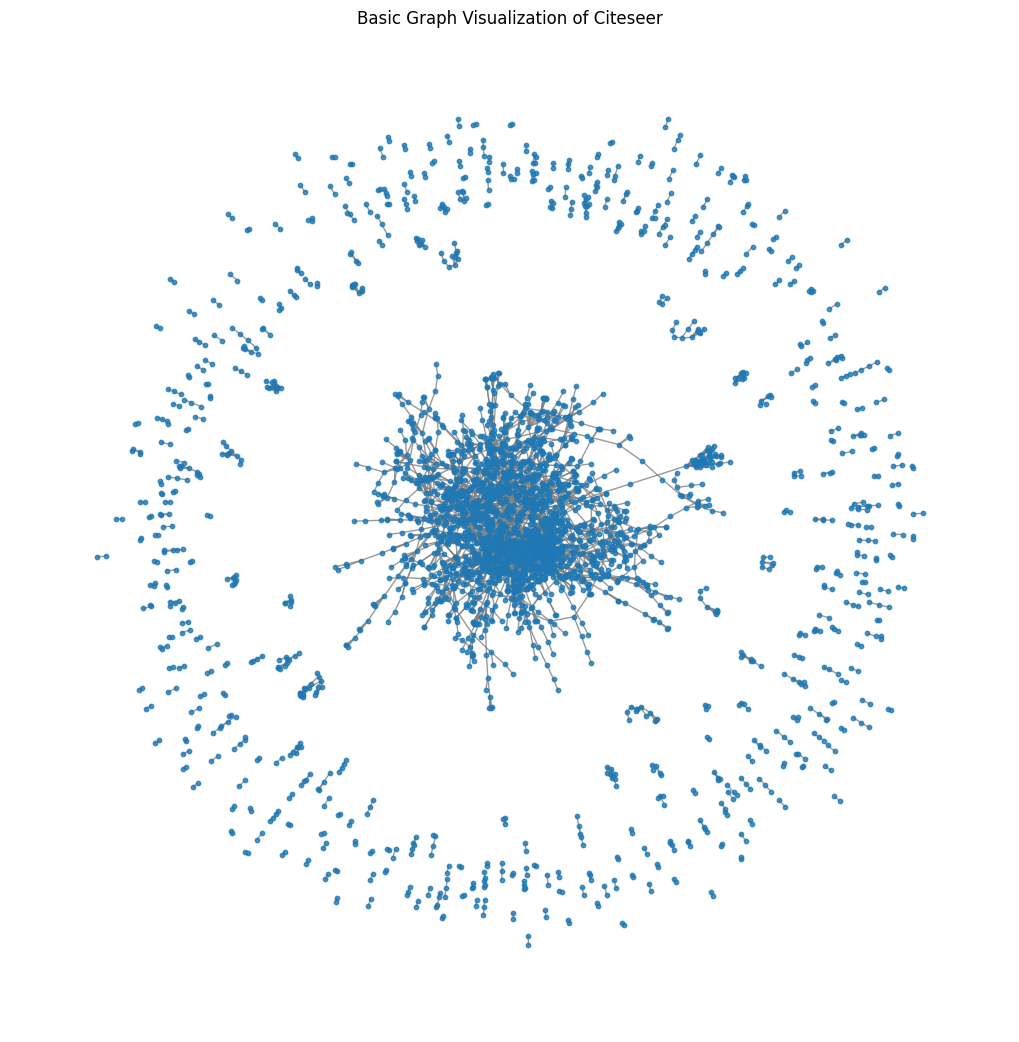

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
G = nx.Graph()
edges = data.edge_index.t().tolist()
G.add_edges_from(edges)
plt.figure(figsize=(10, 10))
nx.draw(G, node_size=10, alpha=0.8, edge_color="gray")
plt.title("Basic Graph Visualization of Citeseer")
plt.show()

### Colored graph

In [ ]:
def visualize_graph(edge_index, labels, num_nodes):
    G = nx.Graph()
    edge_list = edge_index.t().tolist()
    G.add_edges_from(edge_list)
    G.add_nodes_from(range(num_nodes))

    # Ensure labels match number of nodes
    labels = labels[:num_nodes]  # Truncate extra labels if necessary

    # Generate positions for the graph
    pos = nx.spring_layout(G, seed=42)  # Use spring layout for visualization

    plt.figure(figsize=(12, 8))
    nx.draw(
        G,
        pos,
        with_labels=False,
        node_color=labels,
        cmap=plt.cm.rainbow,
        node_size=50,
    )
    plt.title("Citeseer Graph Structure")
    plt.show()

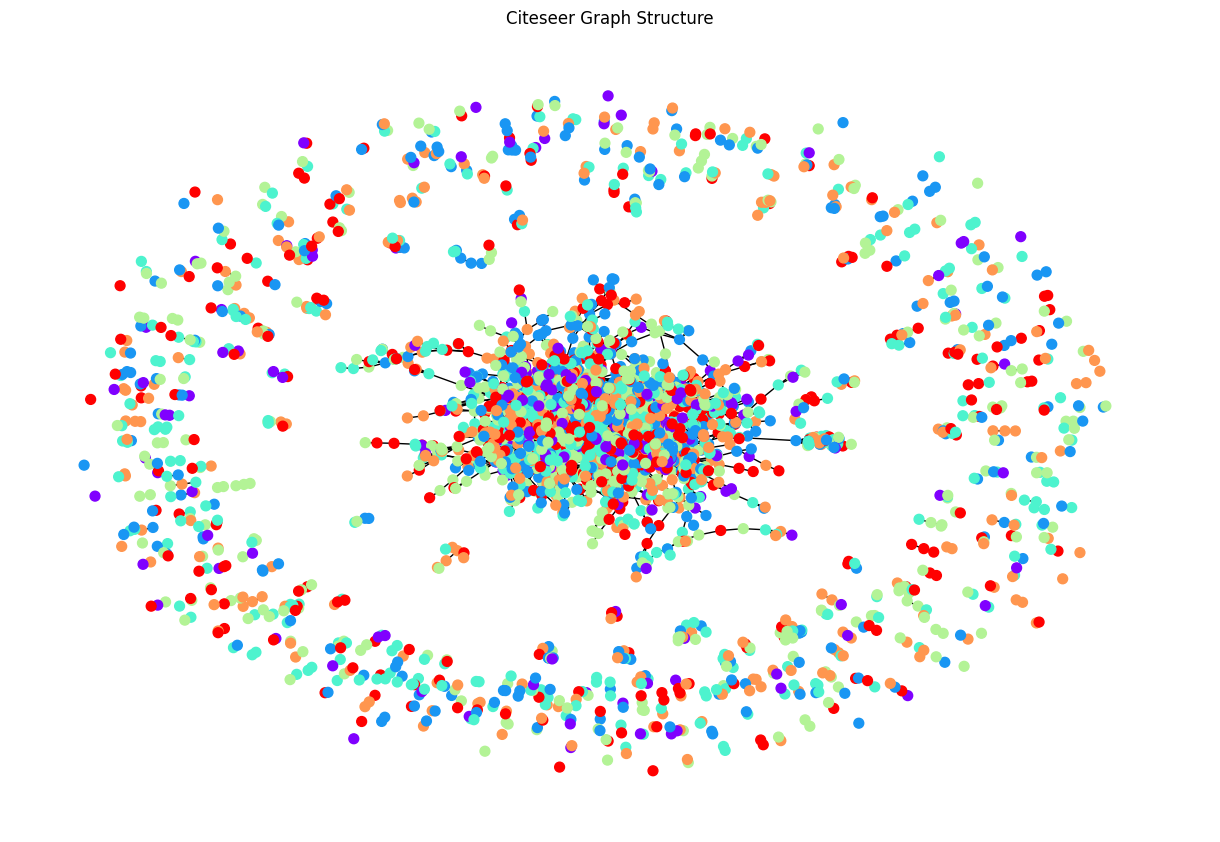

In [ ]:
visualize_graph(data.edge_index, data.y.numpy(), data.num_nodes)

## Model Implementation

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GCNConv

class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)

    def forward(self, x, edge_index):
        # First GCN layer + ReLU
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, p=0.5, training=self.training)

        # Second GCN layer
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)


In [ ]:
# Model hyperparameters
input_dim = dataset.num_features
hidden_dim = 16
output_dim = dataset.num_classes

model = GCN(input_dim, hidden_dim, output_dim)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [ ]:
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def test():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs


In [ ]:
# Training with best accuracy tracking
best_val_acc = 0.0
best_test_acc = 0.0

for epoch in range(200):
    loss = train()
    train_acc, val_acc, test_acc = test()

    # Update best accuracy if validation improves
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc  # Save corresponding test accuracy

    print(f'Epoch {epoch+1:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}')

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Best Test Accuracy: {best_test_acc:.4f}")


Epoch 001, Loss: 1.7912, Train: 0.8167, Val: 0.5120, Test: 0.4670
Epoch 002, Loss: 1.6177, Train: 0.9167, Val: 0.6320, Test: 0.6010
Epoch 003, Loss: 1.3894, Train: 0.9250, Val: 0.6800, Test: 0.6560
Epoch 004, Loss: 1.1517, Train: 0.9250, Val: 0.6880, Test: 0.6490
Epoch 005, Loss: 0.9731, Train: 0.9417, Val: 0.6860, Test: 0.6480
Epoch 006, Loss: 0.7910, Train: 0.9583, Val: 0.6900, Test: 0.6570
Epoch 007, Loss: 0.6898, Train: 0.9750, Val: 0.6880, Test: 0.6720
Epoch 008, Loss: 0.5913, Train: 0.9750, Val: 0.6980, Test: 0.6800
Epoch 009, Loss: 0.4423, Train: 0.9833, Val: 0.6880, Test: 0.6820
Epoch 010, Loss: 0.3776, Train: 1.0000, Val: 0.6800, Test: 0.6710
Epoch 011, Loss: 0.2873, Train: 1.0000, Val: 0.6740, Test: 0.6660
Epoch 012, Loss: 0.2764, Train: 1.0000, Val: 0.6740, Test: 0.6680
Epoch 013, Loss: 0.2281, Train: 1.0000, Val: 0.6660, Test: 0.6640
Epoch 014, Loss: 0.2014, Train: 1.0000, Val: 0.6640, Test: 0.6560
Epoch 015, Loss: 0.1865, Train: 0.9917, Val: 0.6720, Test: 0.6570
Epoch 016,

In [ ]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.loader import DataLoader
import torch.optim as optim

# Load the Citeseer dataset
dataset = Planetoid(root="data/Citeseer", name="Citeseer")

data = dataset[0]  # Citeseer graph object

# Feature normalization (row-normalize)
# Safeguard against division by zero
data.x = data.x / data.x.sum(dim=1, keepdim=True).clamp(min=1e-10)


# Define GCN Model
class GCN(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout_rate):
        super(GCN, self).__init__()
        self.conv1 = GCNConv(input_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, output_dim)
        self.dropout_rate = dropout_rate

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)  # First nonlinearity
        x = F.dropout(x, p=self.dropout_rate, training=self.training)
        x = self.conv2(x, edge_index)
        return F.log_softmax(x, dim=1)

# Hyperparameters
input_dim = dataset.num_node_features  # Number of input features
hidden_dim = 16                        # Number of hidden units (as per GCN paper)
output_dim = dataset.num_classes       # Number of classes
dropout_rate = 0.5                     # Dropout rate
weight_decay = 5e-4                    # L2 regularization factor
learning_rate = 0.01                   # Learning rate
max_epochs = 200                       # Maximum epochs
early_stopping_patience = 10           # Early stopping window size

# Initialize model
model = GCN(input_dim, hidden_dim, output_dim, dropout_rate)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)

# Xavier initialization for GCNConv weights
def init_weights(m):
    if isinstance(m, GCNConv):
        torch.nn.init.xavier_uniform_(m.lin.weight)  # Initialize the linear transformation weights
        if m.bias is not None:
            torch.nn.init.zeros_(m.bias)  # Initialize bias to zeros

# Apply the initialization
model.apply(init_weights)


# Training and evaluation functions
def train():
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = F.nll_loss(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss

@torch.no_grad()
def evaluate():
    model.eval()
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)
    accs = []
    for mask in [data.train_mask, data.val_mask, data.test_mask]:
        correct = (pred[mask] == data.y[mask]).sum()
        accs.append(int(correct) / int(mask.sum()))
    return accs

# Training loop with early stopping
best_val_acc = 0
best_test_acc = 0
patience = 0

for epoch in range(1, max_epochs + 1):
    loss = train()
    train_acc, val_acc, test_acc = evaluate()

    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_test_acc = test_acc
        patience = 0
    else:
        patience += 1

    print(f"Epoch {epoch:03d}, Loss: {loss:.4f}, Train: {train_acc:.4f}, Val: {val_acc:.4f}, Test: {test_acc:.4f}")

    if patience == early_stopping_patience:
        print("Early stopping!")
        break

print(f"Best Validation Accuracy: {best_val_acc:.4f}")
print(f"Corresponding Test Accuracy: {best_test_acc:.4f}")


Epoch 001, Loss: 1.7921, Train: 0.4333, Val: 0.2920, Test: 0.2450
Epoch 002, Loss: 1.7784, Train: 0.6000, Val: 0.3280, Test: 0.2970
Epoch 003, Loss: 1.7648, Train: 0.7500, Val: 0.2620, Test: 0.2280
Epoch 004, Loss: 1.7535, Train: 0.7917, Val: 0.2740, Test: 0.2740
Epoch 005, Loss: 1.7390, Train: 0.8167, Val: 0.3100, Test: 0.3300
Epoch 006, Loss: 1.7291, Train: 0.7750, Val: 0.3160, Test: 0.3460
Epoch 007, Loss: 1.7120, Train: 0.7833, Val: 0.3440, Test: 0.3750
Epoch 008, Loss: 1.6961, Train: 0.8333, Val: 0.3940, Test: 0.4170
Epoch 009, Loss: 1.6860, Train: 0.8667, Val: 0.4780, Test: 0.4740
Epoch 010, Loss: 1.6631, Train: 0.9083, Val: 0.5580, Test: 0.5530
Epoch 011, Loss: 1.6617, Train: 0.9250, Val: 0.6100, Test: 0.6270
Epoch 012, Loss: 1.6340, Train: 0.9417, Val: 0.6300, Test: 0.6420
Epoch 013, Loss: 1.6190, Train: 0.9417, Val: 0.6320, Test: 0.6450
Epoch 014, Loss: 1.6066, Train: 0.9500, Val: 0.6320, Test: 0.6420
Epoch 015, Loss: 1.5794, Train: 0.9500, Val: 0.6240, Test: 0.6310
Epoch 016,